In [1]:
%load_ext autoreload
%cd ./src/homogeneous_nn

/home/etienne/Documents/Univ_Lille/M1/projet recherche/code/src/homogeneous_nn


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from hnn import HomogeneousNN
from plots_utils import plot_model_heatmaps_triptych , plot_mse_vs_dilation_on_test_loader
from hnn_utils import (
    initialize_weights,
    is_diagonalizable,
    compute_alpha_beta,
    batch_bisection_solve_diag, dilation_batch_diag,   # diag/diagonalizable fast path
    batch_bisection_solve,     dilation_batch          # generic matrix_exp fallback
)


# General case

$d(s) = e^{G_d s}$ with $0 \prec G_d$

$||x|| = \sqrt{x^T P x}$ with $0 \prec P$


**Corollary 1:** A linear continuous dilation in $\mathbb{R}^n$ is strictly monotone with respect to the weighted Euclidean norm

$$
\|x\| = \sqrt{x^T P x} \quad \text{with } 0 \prec P \in \mathbb{R}^{n \times n}
$$

if and only if 

$$
P G_d + G_d^T P \succ 0, \quad P \succ 0.
$$

## Finding $s_x \in \mathbb{R}$ such that $||d(-s_x)x|| = 1$

We have $s_x = ln(||x||_d)$

**Lemma 1:** If a linear continuous dilation $\mathbf{d}$ in $\mathbb{R}^n$ is monotone with respect to a norm $\|\cdot\|$, then 1) the function $\|\cdot\|_{\mathbf{d}} : \mathbb{R}^n \to [0,+\infty)$ implicitly defined by (5) is single-valued and continuous on $\mathbb{R}^n$; 2) there exist $\sigma_1, \sigma_2 \in \mathcal{K}_\infty$ such that:

$$
\sigma_1(\|x\|_{\mathbf{d}}) \leq \|x\| \leq \sigma_2(\|x\|_{\mathbf{d}}), \quad \forall x \in \mathbb{R}^n;
$$
$$
\sigma_1(\rho) =
\begin{cases}
    \rho^\alpha, & \text{if } \rho \leq 1, \\
    \rho^\beta, & \text{if } \rho > 1,
\end{cases}
\quad
\sigma_2(\rho) =
\begin{cases}
    \rho^\beta, & \text{if } \rho \leq 1, \\
    \rho^\alpha, & \text{if } \rho > 1.
\end{cases}
$$

$$
\alpha = \frac{\lambda_{\max} \left( P^{\frac{1}{2}} G_d P^{-\frac{1}{2}} + P^{-\frac{1}{2}} G_d^T P^{\frac{1}{2}} \right)}{2}
\geq \beta = \frac{\lambda_{\min} \left( P^{\frac{1}{2}} G_d P^{-\frac{1}{2}} + P^{-\frac{1}{2}} G_d^T P^{\frac{1}{2}} \right)}{2} > 0.
$$

So we have $$min(||x||^{1/\alpha},||x||^{1/\beta}) \leq ||x||_d \leq max(||x||^{1/\alpha},||x||^{1/\beta})$$

$$\implies ln(min(||x||^{1/\alpha},||x||^{1/\beta})) \leq s_x \leq ln(max(||x||^{1/\alpha},||x||^{1/\beta}))$$


Do a sqrt exemple

# Anisotropic simple exemple 

A function $ f: \mathbb{R}^n \to \mathbb{R} $ is said to be $\textbf{homogeneous of degree} \; \nu $ with respect to an anisotropic dilation if it satisfies the scaling relation:

$
f(d(s) x) = e^{\nu s} f(x), \quad \forall x \in \mathbb{R}^n, \forall s \in  \mathbb{R}^n ,
$

where $ d(s) $ is the anisotropic dilation given by:

$
d(s) x = \begin{bmatrix}
e^{r_1 s} & 0 & \cdots & 0 \\
0 & e^{r_2 s} & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & e^{r_d s}
\end{bmatrix} x.
$

ie $
G_d = \begin{bmatrix}
r_1 & 0 & \cdots & 0 \\
0 & r_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & r_n
\end{bmatrix}
$


**Target Function: Sum of Homogeneous Monomials**
We define the function:

$$
f(x_1, x_2) = c_1 |x_1|^{\alpha_{1,1}} |x_2|^{\alpha_{2,1}} + c_2 |x_1|^{\alpha_{1,2}} |x_2|^{\alpha_{2,2}}
$$

where the exponents satisfy the homogeneity condition:

$$
\alpha_{1,k} r_1 + \alpha_{2,k} r_2 = \nu.
$$

For our example:
- $ r_1 = 1, r_2 = 2 $,
- $ \nu = 3 $,

Thus, the function is:

$$
f(x_1, x_2) = 2 |x_1|^2 |x_2|^{0.5} - |x_1|^{0.5} |x_2|^{1.25}.
$$


In [3]:
# Set seed for reproducibility
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# --- Define anisotropic homogeneous function ---
r1, r2 = 1.0, 2.0
nu = 3.0
Gd = torch.diag(torch.tensor([r1, r2], device=device))
P  = torch.eye(2, device=device)

alpha_1 = torch.tensor([2.0, 0.5], device=device)
alpha_2 = torch.tensor([0.5, 1.25], device=device)
coeffs  = torch.tensor([2.0, -1.0], device=device)
assert torch.all(alpha_1 * r1 + alpha_2 * r2 == nu), "Function is not homogeneous"

def f_anisotropic(x):
    """
    Computes the anisotropic homogeneous function f(x).
    """
    terms = torch.stack([
        coeffs[k] * torch.abs(x[:, 0])**alpha_1[k] * torch.abs(x[:, 1])**alpha_2[k]
        for k in range(len(coeffs))
    ], dim=0)
    return terms.sum(dim=0)

cuda


$X_{train}$: $5000$ samples from $\mathcal{U}([-5,5])$

$X_{test}$: $5000$ samples from $\mathcal{U}([-5,5])$

In [4]:
# --- Generate dataset and split into train/test ---

N = 10000
batch_size = 1000
X = torch.randn(N, 2, device=device)
y = f_anisotropic(X).unsqueeze(-1)
full_dataset = TensorDataset(X, y)

train_size = int(0.5 * N)
test_size  = N - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# HNN vs MLP

In [5]:
# Standard MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_layers = 1):
        super().__init__()
        self.name = 'MLP'
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [ ]:
for L in [1,2,4]:
    for m in [16, 32, 64]:
        # --- Define model parameters ---
        hidden_layers = L
        hidden_dim = m
        output_dim = 1
        
        # 1) HomogeneousNN
        model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim,
                                   P=P, Gd=Gd, nu=nu, hidden_layers = hidden_layers).to(device)
        
        # 2) Standard MLP
        model_mlp = MLP(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim, hidden_layers = hidden_layers).to(device)
        
        model_hnn.apply(initialize_weights)
        model_mlp.apply(initialize_weights)
        
        
        # --- Loss and optimizers ---
        criterion = nn.MSELoss()
        opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4)
        opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-4)
        
        # --- Training with validation and test evaluations ---
        num_epochs = 400
        
        train_loss_h = []
        test_loss_h  = []
        train_loss_m = []
        test_loss_m  = []
                
        for epoch in range(num_epochs):
            # ----- training -----
            model_hnn.train(); model_mlp.train()
            for batch_x, batch_y in train_loader:
                # HNN
                opt_hnn.zero_grad()
                loss_h = criterion(model_hnn(batch_x), batch_y)
                loss_h.backward(); opt_hnn.step()
                # MLP
                opt_mlp.zero_grad()
                loss_m = criterion(model_mlp(batch_x), batch_y)
                loss_m.backward(); opt_mlp.step()
        
            # ----- evaluation with final weights of the epoch -----
            model_hnn.eval(); model_mlp.eval()
            train_h = train_m = test_h = test_m = 0.0
            n_train = 0; n_test = 0
            
            with torch.no_grad():

                for bx, by in train_loader:        # TRAIN loss (final weights)
                    bs = bx.size(0); n_train += bs
                    train_h += criterion(model_hnn(bx), by).item() * bs
                    train_m += criterion(model_mlp(bx), by).item() * bs

                for bx, by in test_loader:         # TEST loss
                    bs = bx.size(0); n_test += bs
                    test_h  += criterion(model_hnn(bx), by).item() * bs
                    test_m  += criterion(model_mlp(bx), by).item() * bs
        
            train_loss_h.append(train_h / n_train)
            train_loss_m.append(train_m / n_train)
            test_loss_h.append(test_h / n_test)
            test_loss_m.append(test_m / n_test)
        
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1:3d} | HNN Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
                      f"|| MLP Train: {train_loss_m[-1]:.4f} | Test: {test_loss_m[-1]:.4f}")
        
        print("Training complete.")
        
        # --- Plot loss curves ---
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
        plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
        plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
        plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(f'Loss Curves: HomogeneousNN vs MLP (Train/Test), Layers = {hidden_layer}, Hidden_dim = {hidden_dims}')
        plt.legend()
        plt.grid(True)
        plt.show()


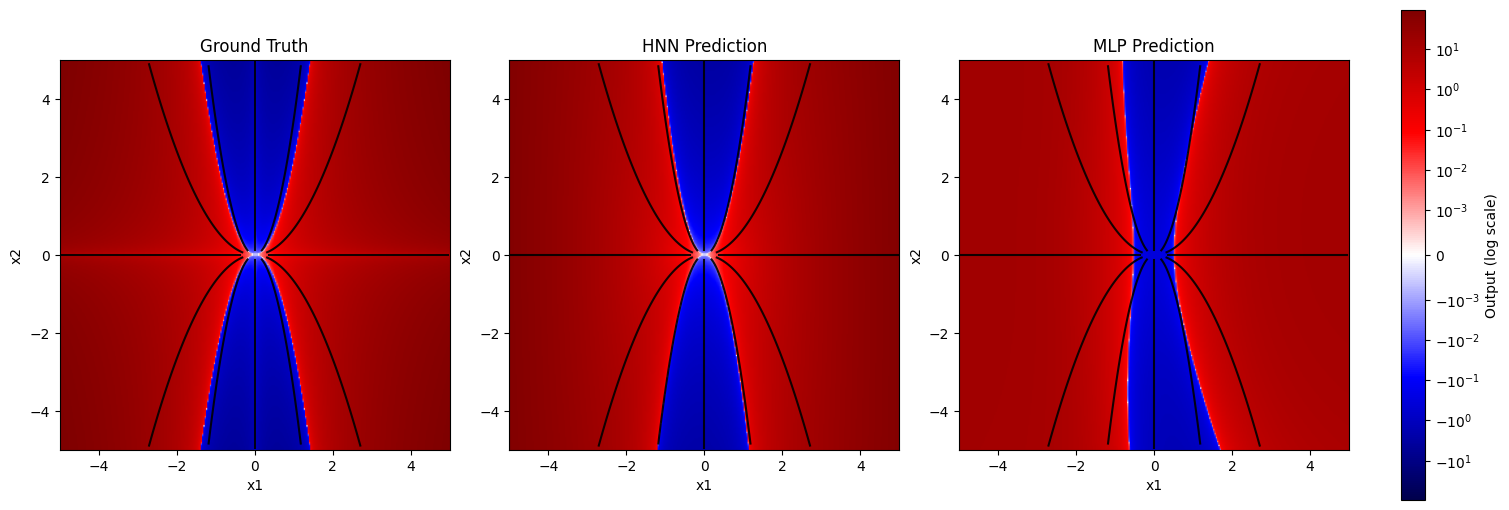

In [6]:
model_hnn.to(device).eval()
model_mlp.to(device).eval()

with torch.no_grad():
    stats = plot_model_heatmaps_triptych(
        model_hnn, model_mlp, f_anisotropic, Gd,
        P=P,
        bound=5.0, grid_size=300, logscale=True,
        overlay_dilation=True,   # show trajectories
        n_start=12,              # starting points on the circle
        s_min=-1.0, ds=0.02,      # grow s from s_min until leaving the box
        max_steps=500,           # safety cap
        unit='P',                # or 'euclidean'
        traj_color='k', traj_lw=1.5, legend_loc='upper left'
    )

Epoch 100 | HNN Train: 1.1043 | Test: 1.2697 || MLP Train: 4.8532 | Test: 4.6391
Epoch 200 | HNN Train: 0.8948 | Test: 1.1302 || MLP Train: 1.4419 | Test: 1.2089
Epoch 300 | HNN Train: 0.7388 | Test: 0.9425 || MLP Train: 1.0727 | Test: 0.8666
Epoch 400 | HNN Train: 0.5191 | Test: 0.7214 || MLP Train: 0.8680 | Test: 0.7102
Training complete.


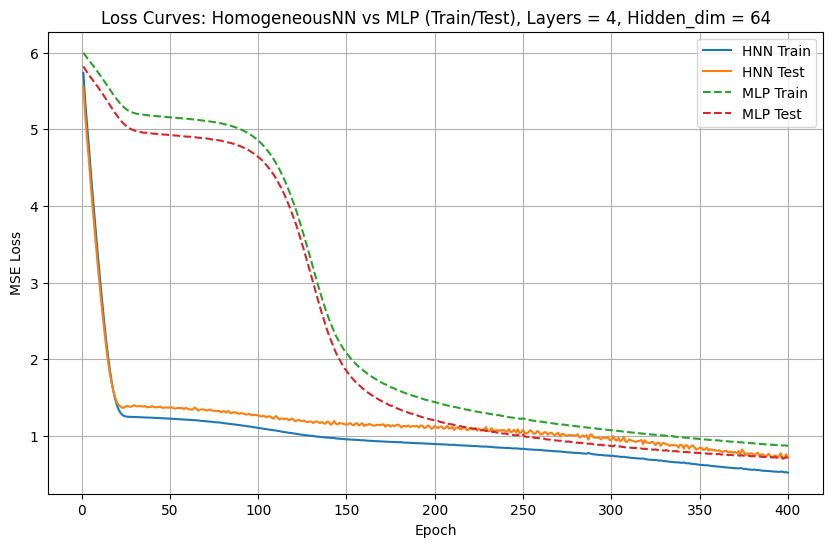

In [ ]:
# --- Define models ---
hidden_layers = 4
hidden_dim = 64
output_dim = 1

model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu, hidden_layers = hidden_layers).to(device)
model_mlp = MLP(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim, hidden_layers = hidden_layers).to(device)

model_hnn.apply(initialize_weights)
model_mlp.apply(initialize_weights)

# --- Loss and optimizers ---
criterion = nn.MSELoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-4)

# --- Training with validation and test evaluations ---
num_epochs = 400

train_loss_h = []
test_loss_h  = []
train_loss_m = []
test_loss_m  = []
        
for epoch in range(num_epochs):
    # ----- training -----
    model_hnn.train(); model_mlp.train()
    for batch_x, batch_y in train_loader:
        # HNN
        opt_hnn.zero_grad()
        loss_h = criterion(model_hnn(batch_x), batch_y)
        loss_h.backward(); opt_hnn.step()
        # MLP
        opt_mlp.zero_grad()
        loss_m = criterion(model_mlp(batch_x), batch_y)
        loss_m.backward(); opt_mlp.step()

    # ----- evaluation with final weights of the epoch -----
    model_hnn.eval(); model_mlp.eval()
    train_h = train_m = test_h = test_m = 0.0
    n_train = 0; n_test = 0
    with torch.no_grad():
        for bx, by in train_loader:        # TRAIN loss (final weights)
            bs = bx.size(0); n_train += bs
            train_h += criterion(model_hnn(bx), by).item() * bs
            train_m += criterion(model_mlp(bx), by).item() * bs
        for bx, by in test_loader:         # TEST loss
            bs = bx.size(0); n_test += bs
            test_h  += criterion(model_hnn(bx), by).item() * bs
            test_m  += criterion(model_mlp(bx), by).item() * bs

    train_loss_h.append(train_h / n_train)
    train_loss_m.append(train_m / n_train)
    test_loss_h.append(test_h / n_test)
    test_loss_m.append(test_m / n_test)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | HNN Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| MLP Train: {train_loss_m[-1]:.4f} | Test: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'Loss Curves: HomogeneousNN vs MLP (Train/Test), Layers = {4}, Hidden_dim = {64}')
plt.legend()
plt.grid(True)
plt.show()

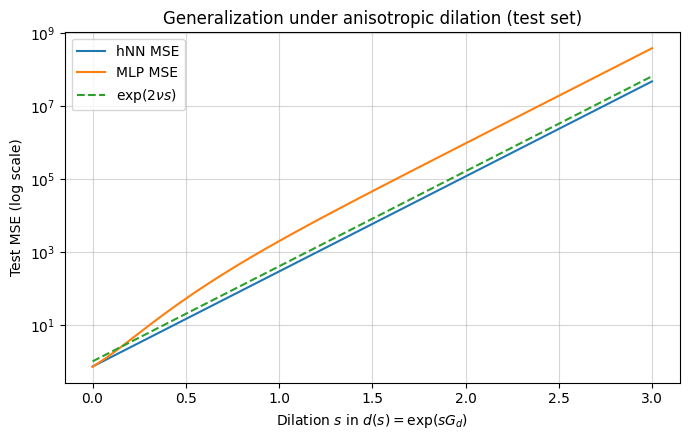

ValueError: too many values to unpack (expected 3)

In [10]:
s_vals, h_mse, m_mse = plot_mse_vs_dilation_on_test_loader(
    model_hnn, model_mlp, f_anisotropic, test_loader, Gd, nu=nu,
    s_min=0.0, s_max=3.0, num_points=40
)

## HNN vs MLP + homogeneity regularization

Homogeneity regularization loss: $\mathcal{L}_h = (||x||_d^\nu f(d(-ln||x||_d)x) - f(x))^2$

In [ ]:
# --- Define models ---
hidden_layers = 4
hidden_dim = 64
output_dim = 1

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu, hidden_layers = hidden_layers).to(device)

# 2) Standard MLP
model_mlp = MLP(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim, hidden_layers = hidden_layers).to(device)

model_hnn.apply(initialize_weights)
model_mlp.apply(initialize_weights)


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=False)
  )
)

Epoch 100 | HNN Train: 1.1211 | Test: 1.2857 || MLP Train: 5.1039 | Test: 4.7515
Epoch 200 | HNN Train: 0.9067 | Test: 1.1028 || MLP Train: 3.3564 | Test: 2.8048
Epoch 300 | HNN Train: 0.7422 | Test: 0.9813 || MLP Train: 2.3552 | Test: 1.7603
Epoch 400 | HNN Train: 0.5311 | Test: 0.7532 || MLP Train: 1.9008 | Test: 1.2704
Epoch 500 | HNN Train: 0.3737 | Test: 0.5268 || MLP Train: 1.6112 | Test: 1.0223
Epoch 600 | HNN Train: 0.2309 | Test: 0.3336 || MLP Train: 1.3896 | Test: 0.8411
Epoch 700 | HNN Train: 0.1398 | Test: 0.2058 || MLP Train: 1.1953 | Test: 0.7011
Epoch 800 | HNN Train: 0.0908 | Test: 0.1267 || MLP Train: 1.0361 | Test: 0.5779
Epoch 900 | HNN Train: 0.0614 | Test: 0.0969 || MLP Train: 0.9396 | Test: 0.5038
Epoch 1000 | HNN Train: 0.0440 | Test: 0.0633 || MLP Train: 0.8202 | Test: 0.4146
Training complete.


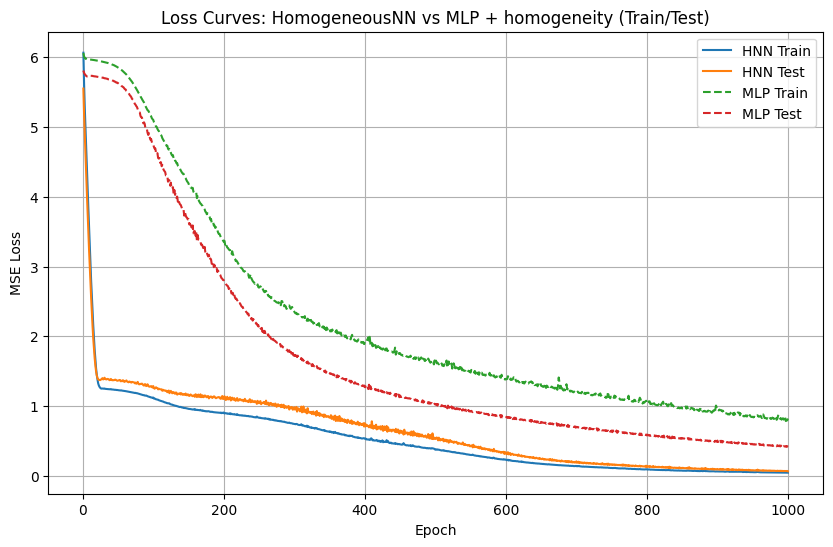

In [ ]:

# ---- Build lam_or_triplet for fast path ----
device = Gd.device
triplet = None
# Diagonal case: pass just the diag vector (lam)
if torch.allclose(Gd, torch.diag(torch.diag(Gd))):
    lam = torch.diag(Gd).to(device)
    triplet = lam
# Diagonalizable with real spectrum: pass (lam, V, V_inv)
elif is_diagonalizable(Gd):
    eigvals, eigvecs = torch.linalg.eig(Gd)
    if torch.allclose(eigvals.imag, torch.zeros_like(eigvals.imag), atol=1e-6):
        lam = eigvals.real.to(device)
        V = eigvecs.to(device)
        V_inv = torch.linalg.inv(V)
        triplet = (lam, V, V_inv)

# Alpha/Beta for the bisection bounds
alpha, beta = compute_alpha_beta(Gd, P)

# --- Loss and optimizers ---
criterion = nn.MSELoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-4, weight_decay=1e-4)

# Optional: weight for the homogeneity regularizer (can tune)
lambda_h = 1.0

# --- Training with validation and test evaluations ---
num_epochs = 1000
train_loss_h, test_loss_h = [], []
train_loss_m, test_loss_m = [], []

for epoch in range(num_epochs):
    # Training phase
    model_hnn.train()
    model_mlp.train()
    running_h = 0.0
    running_m = 0.0

    for batch_x, batch_y in train_loader:
        # ---- HNN ----
        opt_hnn.zero_grad()
        pred_h = model_hnn(batch_x)
        loss_h = criterion(pred_h, batch_y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # ---- MLP + homogeneity constraint ----
        opt_mlp.zero_grad()
        pred_m = model_mlp(batch_x)

        with torch.no_grad():
            if triplet is not None:
                # fast path
                S = batch_bisection_solve_diag(triplet, P, batch_x, alpha, beta, tol=1e-4, max_iter=1000)
                x_sphere = dilation_batch_diag(triplet, -S, batch_x)
            else:
                # generic path
                S = batch_bisection_solve(Gd, P, batch_x, alpha, beta, tol=1e-4, max_iter=1000)
                x_sphere = dilation_batch(Gd, -S, batch_x)

        scale_up = torch.exp(nu * S).unsqueeze(-1)  # e^{νS}

        mse = criterion(pred_m, batch_y)
        # f(x) ≈ e^{νS} f(d(-S)x)
        h_constraint = criterion(pred_m, scale_up * model_mlp(x_sphere))
        loss_m = mse + lambda_h * h_constraint

        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    # ---- Evaluation phase ----
    model_hnn.eval()
    model_mlp.eval()
    test_h = 0.0
    test_m = 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            ph = model_hnn(bx)
            pm = model_mlp(bx)
            test_h += criterion(ph, by).item()
            test_m += criterion(pm, by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | HNN Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| MLP Train: {train_loss_m[-1]:.4f} | Test: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP + homogeneity (Train/Test)')
plt.legend(); plt.grid(True); plt.show()


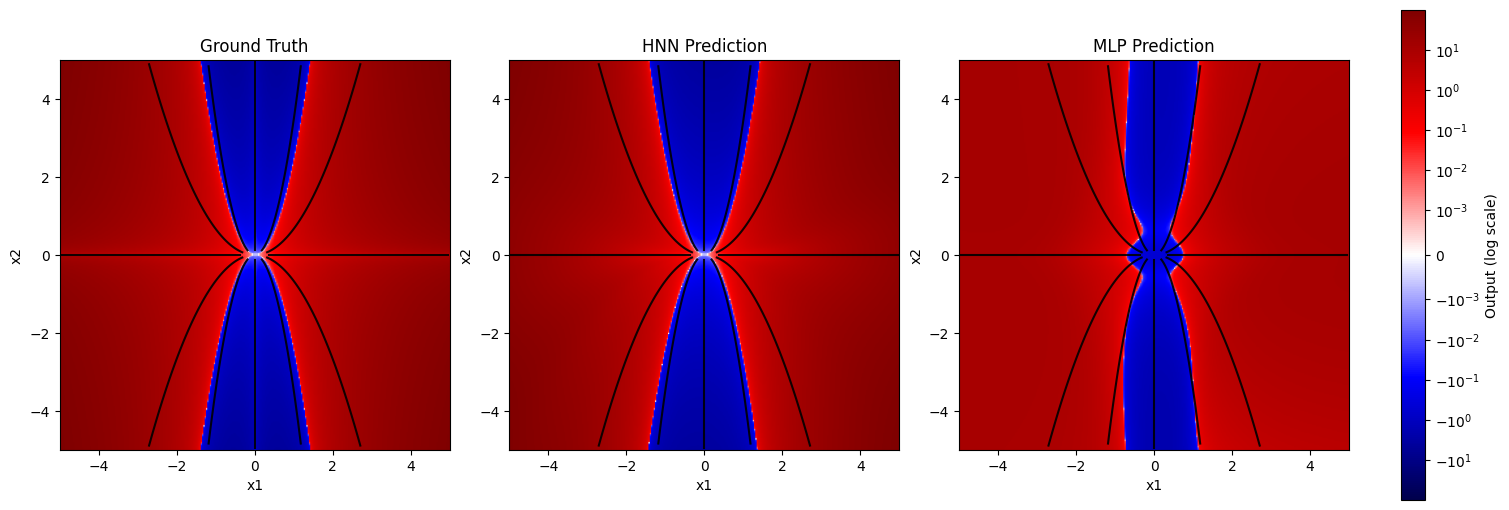

In [12]:
model_hnn.to(device).eval()
model_mlp.to(device).eval()

with torch.no_grad():
    stats = plot_model_heatmaps_triptych(
        model_hnn, model_mlp, f_anisotropic, Gd,
        P=P,
        bound=5.0, grid_size=300, logscale=True,
        overlay_dilation=True,   # show trajectories
        n_start=12,              # starting points on the circle
        s_min=-1.0, ds=0.02,      # grow s from s_min until leaving the box
        max_steps=500,           # safety cap
        unit='P',                # or 'euclidean'
        traj_color='k', traj_lw=1.5, legend_loc='upper left'
    )

# HNN MSE vs HNN Homogeneous weigthed loss

In [6]:
# --- Define models ---
hidden_dim = 128
output_dim = 1

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

model_hnn_WL = HomogeneousNN(input_dim=2, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

model_hnn.apply(initialize_weights)
model_hnn_WL.apply(initialize_weights)

HomogeneousNN(
  (net_on_sphere): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=False)
  )
)

In [7]:
def hnn_loss(pred_y, target_y, S, nu):
    mse = (pred_y - target_y)**2
    weights = S.unsqueeze(-1)
    weighted_mse = weights * mse
    return weighted_mse.mean()

Epoch 100 | HNN (MSE) Train: 1.2848 | Test: 1.3859 || HNN (Weighted) Train: 0.7108 | Test: 0.8498
Epoch 200 | HNN (MSE) Train: 1.2680 | Test: 1.4051 || HNN (Weighted) Train: 0.6732 | Test: 0.8893
Epoch 300 | HNN (MSE) Train: 1.2674 | Test: 1.4041 || HNN (Weighted) Train: 0.6732 | Test: 0.8894
Epoch 400 | HNN (MSE) Train: 1.2664 | Test: 1.4044 || HNN (Weighted) Train: 0.6730 | Test: 0.8902
Epoch 500 | HNN (MSE) Train: 1.2652 | Test: 1.4035 || HNN (Weighted) Train: 0.6729 | Test: 0.8908
Epoch 600 | HNN (MSE) Train: 1.2638 | Test: 1.4010 || HNN (Weighted) Train: 0.6727 | Test: 0.8883
Epoch 700 | HNN (MSE) Train: 1.2623 | Test: 1.4015 || HNN (Weighted) Train: 0.6727 | Test: 0.8912
Epoch 800 | HNN (MSE) Train: 1.2601 | Test: 1.3973 || HNN (Weighted) Train: 0.6724 | Test: 0.8877
Epoch 900 | HNN (MSE) Train: 1.2579 | Test: 1.3979 || HNN (Weighted) Train: 0.6723 | Test: 0.8909
Epoch 1000 | HNN (MSE) Train: 1.2550 | Test: 1.3926 || HNN (Weighted) Train: 0.6720 | Test: 0.8869
Training complete.


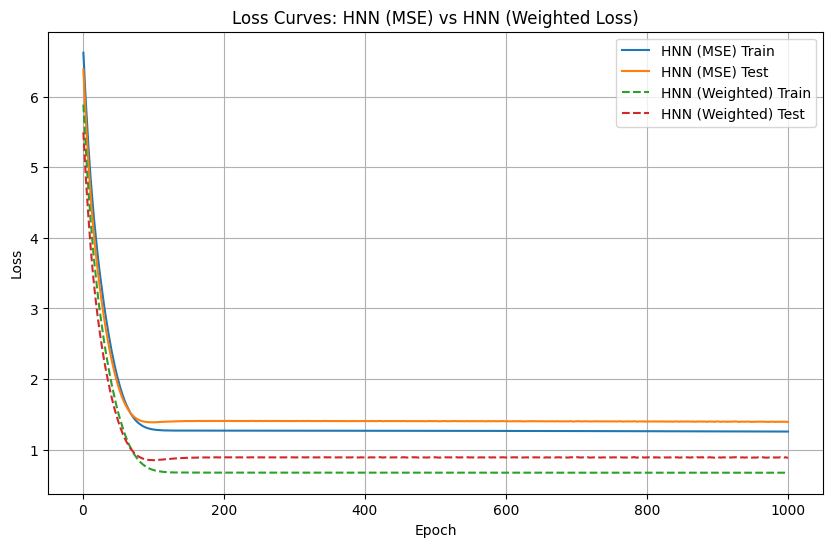

In [14]:
device = Gd.device
triplet = None
# Diagonal case: pass just the diag vector (lam)
if torch.allclose(Gd, torch.diag(torch.diag(Gd))):
    lam = torch.diag(Gd).to(device)
    triplet = lam
# Diagonalizable with real spectrum: pass (lam, V, V_inv)
elif is_diagonalizable(Gd):
    eigvals, eigvecs = torch.linalg.eig(Gd)
    if torch.allclose(eigvals.imag, torch.zeros_like(eigvals.imag), atol=1e-6):
        lam = eigvals.real.to(device)
        V = eigvecs.to(device)
        V_inv = torch.linalg.inv(V)
        triplet = (lam, V, V_inv)

# Alpha/Beta for the bisection bounds
alpha, beta = compute_alpha_beta(Gd, P)

# --- Loss and optimizers ---
criterion = nn.MSELoss()
opt_hnn     = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_hnn_WL  = optim.Adam(model_hnn_WL.parameters(), lr=1e-4, weight_decay=1e-4)

# --- Training setup ---
num_epochs = 1000
train_loss_h     = []
test_loss_h      = []
train_loss_hWL   = []
test_loss_hWL    = []

for epoch in range(num_epochs):
    model_hnn.train()
    model_hnn_WL.train()
    running_h = 0.0
    running_hWL = 0.0

    for batch_x, batch_y in train_loader:
        # --- Standard HNN with MSE ---
        opt_hnn.zero_grad()
        pred_h = model_hnn(batch_x)
        loss_h = criterion(pred_h, batch_y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # --- HNN with Weighted Loss ---
        opt_hnn_WL.zero_grad()
        pred_hWL = model_hnn_WL(batch_x)

        with torch.no_grad():
            S = batch_bisection_solve_diag(triplet, P, batch_x, alpha, beta)

        loss_hWL = hnn_loss(pred_hWL, batch_y, S, nu)
        loss_hWL.backward()
        opt_hnn_WL.step()
        running_hWL += loss_hWL.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_hWL.append(running_hWL / len(train_loader))

    # --- Evaluation phase ---
    model_hnn.eval()
    model_hnn_WL.eval()
    test_h, test_hWL = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            ph = model_hnn(bx)
            phWL = model_hnn_WL(bx)
            S = batch_bisection_solve_diag(triplet, P, bx, alpha, beta)
            test_h += criterion(ph, by).item()
            test_hWL += hnn_loss(phWL, by, S, nu).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_hWL.append(test_hWL / len(test_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:3d} | HNN (MSE) Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| HNN (Weighted) Train: {train_loss_hWL[-1]:.4f} | Test: {test_loss_hWL[-1]:.4f}")

print("Training complete.")
# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN (MSE) Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN (MSE) Test')
plt.plot(range(1, num_epochs+1), train_loss_hWL, label='HNN (Weighted) Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_hWL,  label='HNN (Weighted) Test', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves: HNN (MSE) vs HNN (Weighted Loss)')
plt.legend()
plt.grid(True)
plt.show()



In [15]:
bound = 5
plot_model_heatmaps(model_hnn, f_anisotropic, Gd, P, nu, bound)
plot_model_heatmaps(model_hnn_WL, f_anisotropic, Gd, P, nu, bound)

NameError: name 'plot_model_heatmaps' is not defined

Still better performance